GET CLUSTER LABELS BEFORE RUNNING THIS PIPELINE!

Set the sample dataset id and number of k clusters

In [1]:
sample = 1
k = 10

Compress create csc and csr formats

In [2]:
from compressor import compress
from scipy.io import mmread
from scipy.sparse import save_npz
import numpy as np
import os

label_path = 'compressed/neural/sample'+str(sample)+'/k'+str(k)+'/cluster_labels.pkl'
matrix_path = 'data/sample'+str(sample)+'/matrix.mtx'
out_path = 'compressed/neural/sample'+str(sample)+'/k'+str(k)

sparse_matrix = mmread(matrix_path)
csr = sparse_matrix.tocsr()
save_npz('data/sample'+str(sample)+'/csr.npz', csr)
output_prefix = 'data/sample'+str(sample)+'/csr_nozip/csr'
if not os.path.isdir('data/sample'+str(sample)+'/csr_nozip'):
    os.mkdir('data/sample'+str(sample)+'/csr_nozip')
np.save(f"{output_prefix}_data.npy", csr.data)
np.save(f"{output_prefix}_indices.npy", csr.indices)
np.save(f"{output_prefix}_indptr.npy", csr.indptr)
np.save(f"{output_prefix}_shape.npy", np.array(csr.shape))

csc = sparse_matrix.tocsc()
save_npz('data/sample'+str(sample)+'/csc.npz', csc)
output_prefix = 'data/sample'+str(sample)+'/csc_nozip/csc'
if not os.path.isdir('data/sample'+str(sample)+'/csc_nozip'):
    os.mkdir('data/sample'+str(sample)+'/csc_nozip')
np.save(f"{output_prefix}_data.npy", csc.data)
np.save(f"{output_prefix}_indices.npy", csc.indices)
np.save(f"{output_prefix}_indptr.npy", csc.indptr)
np.save(f"{output_prefix}_shape.npy", np.array(csc.shape))

Compress using our compressor

In [3]:
compress(label_path, matrix_path, out_path)

Apply gzip

In [4]:
import shutil

# copy cluster_genes.csv from high level to low level
def copy_file(source_path, destination_path):
    """Copies a file from the source path to the destination path.

    Args:
        source_path: The path to the file to be copied.
        destination_path: The path to the destination directory.
    """
    try:
         shutil.copy(source_path, destination_path)
         print(f"File copied successfully from {source_path} to {destination_path}")
    except FileNotFoundError:
        print(f"Error: Source file not found: {source_path}")
    except PermissionError:
         print(f"Error: Permission denied to access {source_path} or {destination_path}")
    except Exception as e:
         print(f"An unexpected error occurred: {e}")
    
copy_file(out_path + '/high_level_compress/cluster_genes.csv', out_path + '/low_level_compress')

# gzip high_level_compress dir and low_level_compress dir
import subprocess
subprocess.run(["zip", "-r", out_path + '/high_level_compress.gz', out_path + '/high_level_compress'])
subprocess.run(["zip", "-r", out_path + '/low_level_compress.gz', out_path + '/low_level_compress'])
subprocess.run(["zip", "-r", 'data/sample'+str(sample)+'/matrix.gz', 'data/sample'+str(sample)+'/matrix.mtx'])

File copied successfully from compressed/neural/sample1/k10/high_level_compress/cluster_genes.csv to compressed/neural/sample1/k10/low_level_compress
  adding: compressed/neural/sample1/k10/high_level_compress/ (stored 0%)
  adding: compressed/neural/sample1/k10/high_level_compress/counts.csv (deflated 82%)
  adding: compressed/neural/sample1/k10/high_level_compress/cluster_genes.csv (deflated 62%)
  adding: compressed/neural/sample1/k10/high_level_compress/deltas.csv (deflated 64%)
  adding: compressed/neural/sample1/k10/low_level_compress/ (stored 0%)
  adding: compressed/neural/sample1/k10/low_level_compress/cluster_genes.csv (deflated 62%)
  adding: compressed/neural/sample1/k10/low_level_compress/huffman_encoded_deltas (deflated 1%)
  adding: compressed/neural/sample1/k10/low_level_compress/huffman_encoded_counts (deflated 3%)
  adding: compressed/neural/sample1/k10/low_level_compress/counts_huffman_tree (deflated 89%)
  adding: compressed/neural/sample1/k10/low_level_compress/del

CompletedProcess(args=['zip', '-r', 'data/sample1/matrix.gz', 'data/sample1/matrix.mtx'], returncode=0)

Verify compression works

In [5]:
from compressor import high_level_decompress, low_level_decompress

in_path = 'compressed/neural/sample'+str(sample)+'/k'+str(k)
high_level_decompress(in_path, matrix_path)
low_level_decompress(in_path)

High Level Accuracy Check Passed
deltas huffman : ENCODED CORRECTLY!
counts huffman : ENCODED CORRECTLY!


Generate plots

[(52.88, 'MTX', 'blue'), (51, 'CSR', 'blue'), (51, 'CSC', 'blue'), (32.43, 'H10 (ours)', 'green'), (13.68, 'MTX.gz', 'purple'), (10.09, 'H10.gz (ours)', 'red'), (8.72, 'L10 (ours)', 'green'), (8.7, 'CSC.gz', 'purple'), (8.51, 'CSR.gz', 'purple'), (7.62, 'L10.gz (ours)', 'red')]


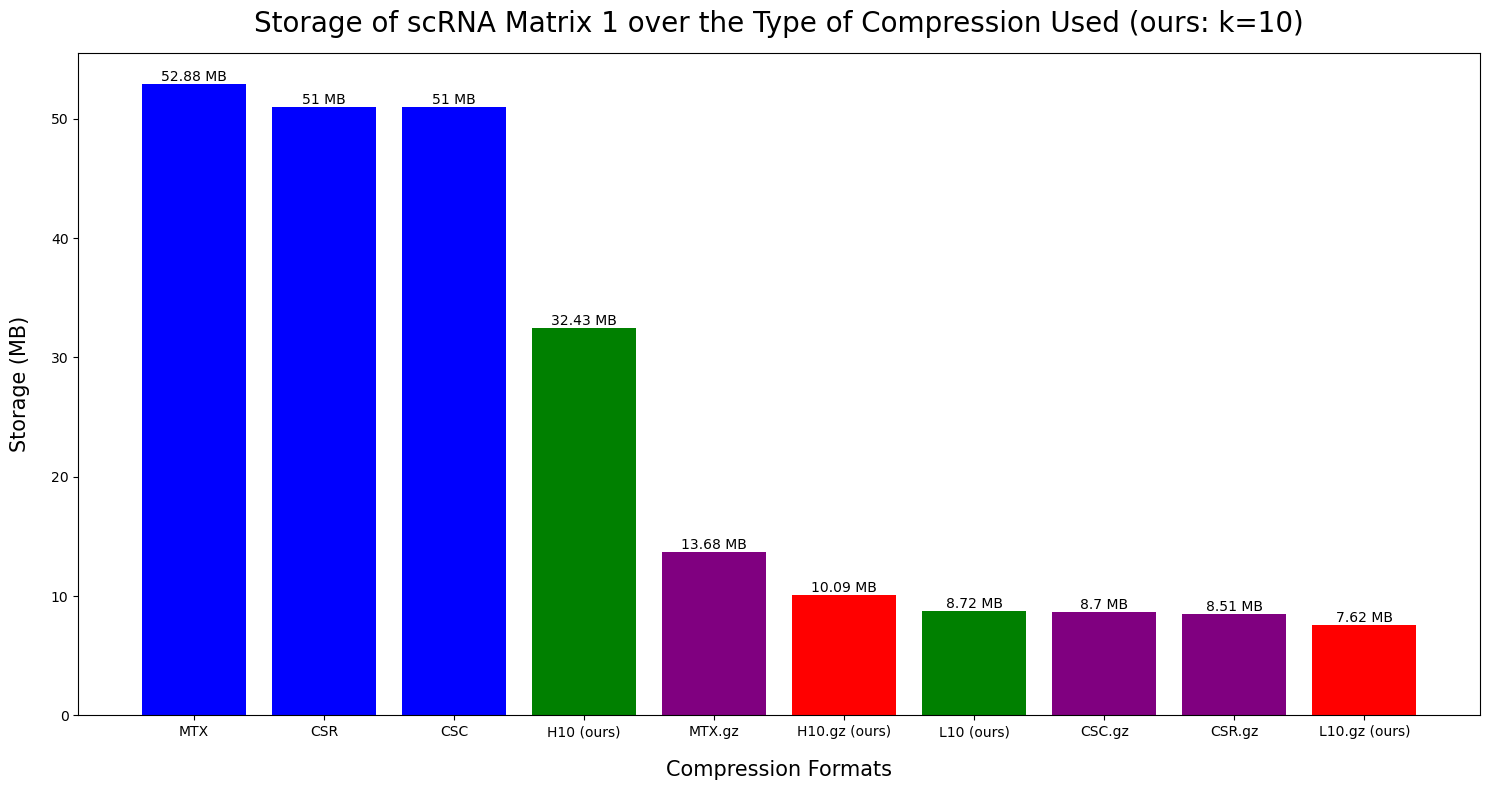

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Code retrieved from https://stackoverflow.com/a/1392549
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return round(total_size/1000000,2)

storage_data = []
storage_data.append((get_size(out_path + '/high_level_compress'), 'H'+str(k)+' (ours)', 'green'))
storage_data.append((round(os.path.getsize(out_path + '/high_level_compress.gz')/1000000,2), 'H'+str(k)+'.gz (ours)', 'red'))
storage_data.append((get_size(out_path + '/low_level_compress'), 'L'+str(k)+' (ours)', 'green'))
storage_data.append((round(os.path.getsize(out_path + '/low_level_compress.gz')/1000000,2), 'L'+str(k)+'.gz (ours)', 'red'))
storage_data.append((round(get_size('data/sample'+str(sample)+'/csc_nozip')), 'CSC', 'blue'))
storage_data.append((round(os.path.getsize('data/sample'+str(sample)+'/csc.npz')/1000000,2), 'CSC.gz', 'purple'))
storage_data.append((round(get_size('data/sample'+str(sample)+'/csr_nozip')), 'CSR', 'blue'))
storage_data.append((round(os.path.getsize('data/sample'+str(sample)+'/csr.npz')/1000000,2), 'CSR.gz', 'purple'))
storage_data.append((round(os.path.getsize('data/sample'+str(sample)+'/matrix.mtx')/1000000,2), 'MTX', 'blue'))
storage_data.append((round(os.path.getsize('data/sample'+str(sample)+'/matrix.gz')/1000000,2), 'MTX.gz', 'purple'))

storage_data.sort(reverse=True)
categories = [x[1] for x in storage_data]
values = [x[0] for x in storage_data]
colors = [x[2] for x in storage_data]
print(storage_data)

# Create the bar chart
plt.figure(figsize=(15, 8))
plt.bar(categories, values, color = colors)

# Add values on top of bars
for i in range(len(categories)):
    plt.text(i, values[i], str(values[i]) + ' MB', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Compression Formats', fontsize=15, labelpad=15)
plt.ylabel('Storage (MB)', fontsize=15, labelpad=15)
plt.title('Storage of scRNA Matrix '+str(sample)+' over the Type of Compression Used (ours: k='+str(k)+')', fontsize=20, pad=15)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the fig
plt.savefig(out_path + '/storage_comparisons.png', dpi=300, bbox_inches='tight')

# Display the chart
plt.show()